# Baseline Models 

We can compare to baseline weather prediction models. A persistence baseline is one where tomorrow's prediction is today's weather. A climatology forecast baseline averages historical data for a prediction that matches the climate of the region, but pays no attention to the dynamism of day to day weather. 

We create forecasts using different baseline models.

In [6]:
# !pip install xarray==0.19.0
# !pip install climetlab
# !pip install climetlab_weatherbench
# !pip install numexpr=='2.7.3'

In [2]:
import xarray as xr
import climetlab as cml
import numpy as np
from src.utils import *

In [9]:
# Load Data
us_temp_data = xr.open_mfdataset('../data/us_temperature.nc')
us_rain_data = xr.open_mfdataset('../data/us_precipitation.nc')

In [10]:
# Normalize datasets
us_temp_data = normalize(us_temp_data).t2m
us_rain_data = normalize(us_rain_data).tp

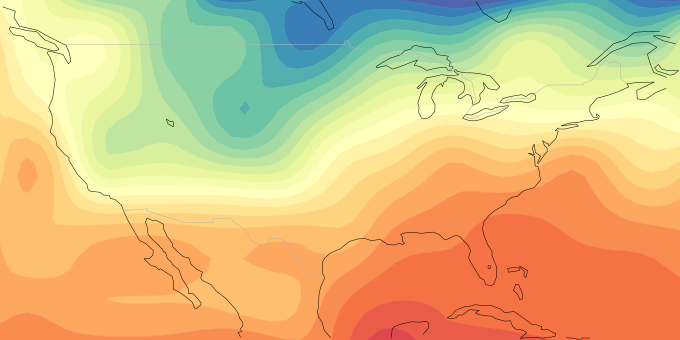

In [11]:
plot_temp(us_temp_data[-1])

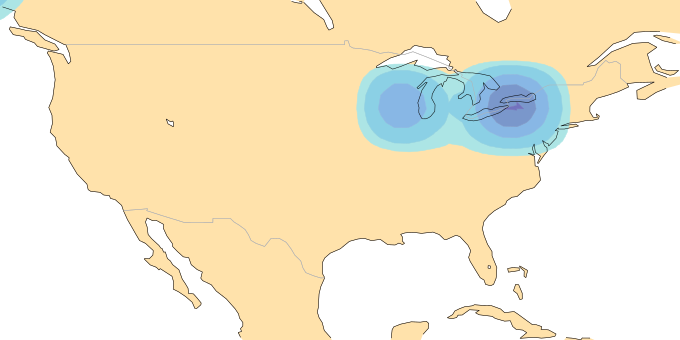

In [12]:
plot_rain(us_rain_data[-1])

## Persistence Model
This simplistic way of forecasting, where usually what is done is persisting previous weather conditions as forecast. However, as this doesn't make much sense based on how weather works, we instead persist the hourly changes from the past. Given some lead time, assume the next lead_time hours prediction is equal to the previous lead_time hours.


In [13]:
def persistence_forecast(data, lead_time_in_hours):
    forecasts = data[- lead_time_in_hours:]
    pred_times = np.array([data.time[- 1].values + 36*10**11*i for i in range(1, lead_time_in_hours+1)])
    pred_times = xr.DataArray(pred_times, dims=['time'], coords={'time': pred_times}, name='time')
    forecasts = xr.concat(forecasts, pred_times)
    return forecasts

In [14]:
lead_time = 30*24
us_temp_test = us_temp_data.sel(time=us_temp_data.time[- lead_time:])
us_temp_train = us_temp_data.sel(time=us_temp_data.time[: - lead_time])

In [15]:
us_temp_pred = persistence_forecast(us_temp_train, lead_time)

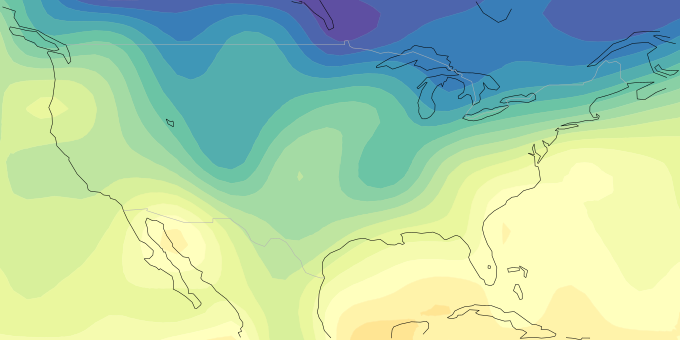

(numpy.datetime64('2018-12-02T00:00:00.000000000'), None)

In [16]:
# first hour of prediction
a = normalize(us_temp_pred[0])
a.time.values, plot_temp(a)

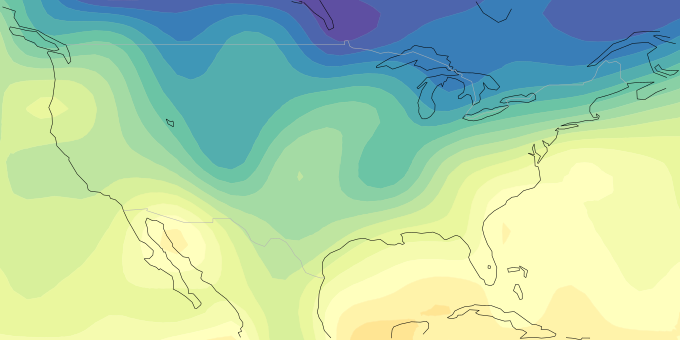

(numpy.datetime64('2018-11-02T00:00:00.000000000'), None)

In [17]:
# last month value
a = normalize(us_temp_data[-2* lead_time])
a.time.values, plot_temp(a)

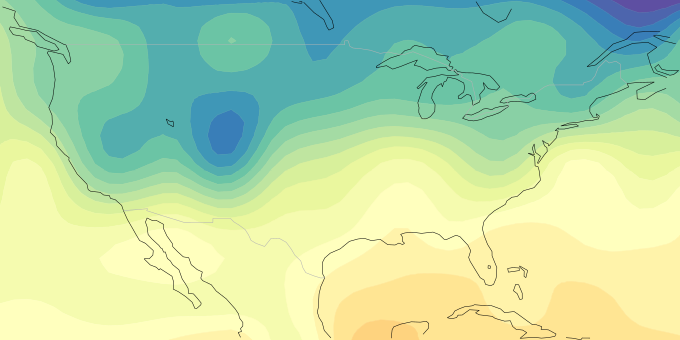

(numpy.datetime64('2018-12-02T00:00:00.000000000'), None)

In [18]:
# first hour of prediction
a = normalize(us_temp_test[0])
a.time.values, plot_temp(a)

In [19]:
us_temp_pred

,Array,Chunk
Bytes,262.08 kB,364 B
Shape,"(720, 7, 13)","(1, 7, 13)"
Count,2168 Tasks,720 Chunks
Type,float32,numpy.ndarray


In [21]:
us_temp_pred.to_netcdf('../data/us_temperature_persistence_forecast.nc')

Now we predict total precipitation

In [22]:
lead_time = 30*24
us_rain_test = us_rain_data.sel(time=us_rain_data.time[- lead_time:])
us_rain_train = us_rain_data.sel(time=us_rain_data.time[: - lead_time])

In [23]:
us_rain_pred = persistence_forecast(us_rain_train, lead_time)

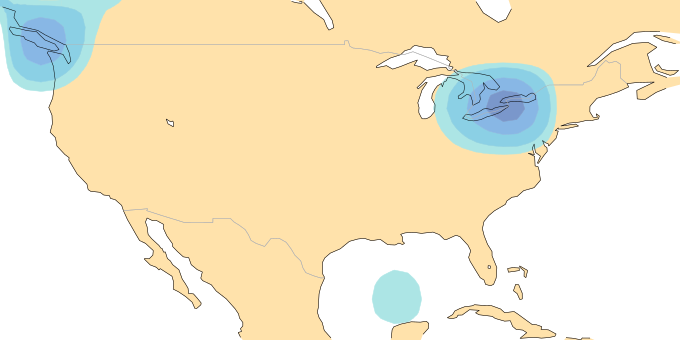

(numpy.datetime64('2018-12-02T00:00:00.000000000'), None)

In [24]:
# first hour of prediction
a = normalize(us_rain_pred[0])
a.time.values, plot_rain(a)

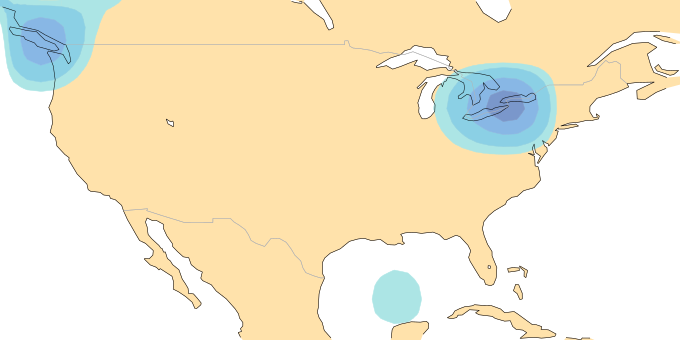

(numpy.datetime64('2018-11-02T00:00:00.000000000'), None)

In [25]:
# last month value
a = normalize(us_rain_data[-2* lead_time])
a.time.values, plot_rain(a)

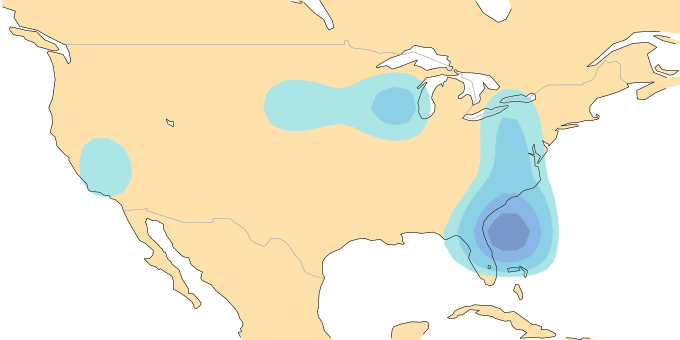

(numpy.datetime64('2018-12-02T00:00:00.000000000'), None)

In [26]:
# first hour of prediction
a = normalize(us_rain_test[0])
a.time.values, plot_rain(a)

In [27]:
us_rain_pred

,Array,Chunk
Bytes,262.08 kB,364 B
Shape,"(720, 7, 13)","(1, 7, 13)"
Count,2168 Tasks,720 Chunks
Type,float32,numpy.ndarray


In [29]:
us_rain_pred.to_netcdf('../data/us_precipitation_persistence_forecast.nc')

## Climatology Models
We perform climatology by week.

In [30]:
def total_climatology_forecast(data):
    return normalize(data.mean('time'))

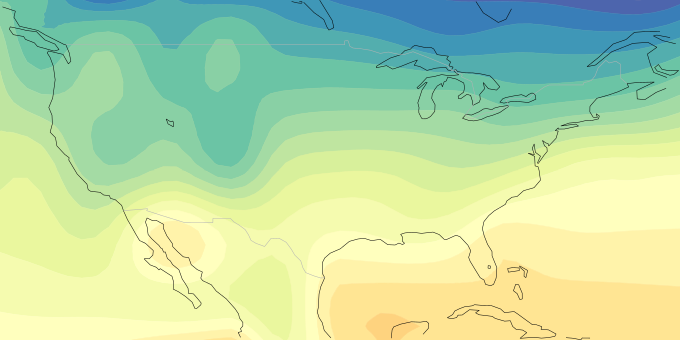

<xarray.DataArray 't2m' (lat: 7, lon: 13)>
dask.array<truediv, shape=(7, 13), dtype=float32, chunksize=(7, 13), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 230.6 236.2 241.9 247.5 ... 281.2 286.9 292.5 298.1
  * lat      (lat) float64 19.69 25.31 30.94 36.56 42.19 47.81 53.44

In [31]:
total_climatology_temp = total_climatology_forecast(us_temp_train)
plot_temp(total_climatology_temp)
total_climatology_temp

In [32]:
total_climatology_temp.to_netcdf("../data/us_temperature_climatology_forecast_singleday.nc")

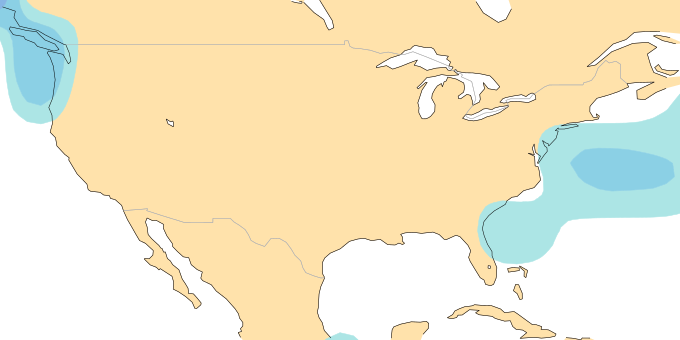

<xarray.DataArray 'tp' (lat: 7, lon: 13)>
dask.array<truediv, shape=(7, 13), dtype=float32, chunksize=(7, 13), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 19.69 25.31 30.94 36.56 42.19 47.81 53.44
  * lon      (lon) float64 230.6 236.2 241.9 247.5 ... 281.2 286.9 292.5 298.1

In [33]:
total_climatology_rain = total_climatology_forecast(us_rain_train)
plot_rain(total_climatology_rain)
total_climatology_rain

In [34]:
total_climatology_rain.to_netcdf("../data/us_precipitation_climatology_forecast_singleday.nc")

In [35]:
def daily_climatology_forecast(data, lead_time_in_days):
    lead_time = lead_time_in_days*24
    hourly_forecasts = []
    for j in range(24):
        climatology_sum = xr.zeros_like(data[0])
        total_years = len(data.time)//(24*365)
        for k in range(total_years):
            climatology_sum += data[k*24*365 + ((17+j)%24)]
        climatology_sum /= total_years
        hourly_forecasts.append(climatology_sum)

    forecasts = []
    for i in range(lead_time_in_days):
        forecasts.extend(hourly_forecasts)

    pred_times = np.array([data.time[- 1].values + 36*10**11*i for i in range(1, lead_time+1)])
    pred_times = xr.DataArray(pred_times, dims=['time'], coords={'time': pred_times}, name='time')
    forecasts = xr.concat(forecasts, pred_times)
    return normalize(forecasts)

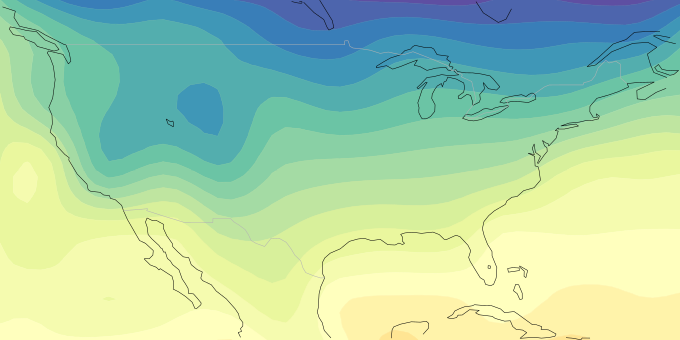

,Array,Chunk
Bytes,262.08 kB,364 B
Shape,"(720, 7, 13)","(1, 7, 13)"
Count,4090 Tasks,720 Chunks
Type,float32,numpy.ndarray


In [36]:
us_hourly_climatology_temperature = daily_climatology_forecast(us_temp_train, 30)
plot_temp(us_hourly_climatology_temperature[0])
us_hourly_climatology_temperature

In [37]:
us_hourly_climatology_temperature.to_netcdf('../data/us_temperature_hourly_climatology_forecast.nc')

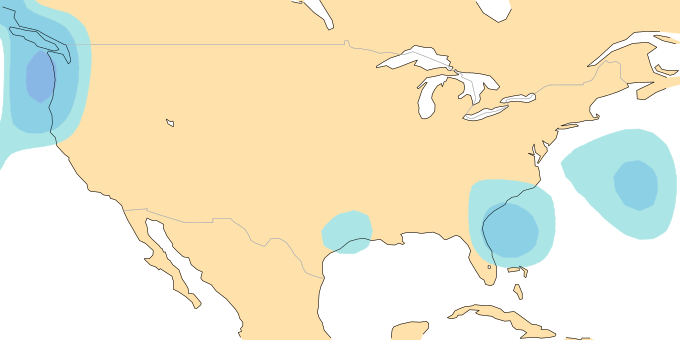

,Array,Chunk
Bytes,262.08 kB,364 B
Shape,"(720, 7, 13)","(1, 7, 13)"
Count,4090 Tasks,720 Chunks
Type,float32,numpy.ndarray


In [38]:
us_hourly_climatology_precipitation = daily_climatology_forecast(us_rain_train, 30)
plot_rain(us_hourly_climatology_precipitation[0])
us_hourly_climatology_precipitation

In [39]:
us_hourly_climatology_precipitation.to_netcdf('../data/us_precipitation_hourly_climatology_forecast.nc')

# Linear Regression Model

In [3]:
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
# Load Data
us_temp_data = xr.open_mfdataset('../data/us_temperature.nc').t2m
us_rain_data = xr.open_mfdataset('../data/us_precipitation.nc').tp

us_temp_data = us_temp_data[7:]
assert np.all(us_rain_data.time == us_temp_data.time)
data = xr.merge([us_temp_data, us_rain_data])

# Split into train and test data
data_train = normalize(data.sel(time=slice('2018')))
data_test = normalize(data.sel(time=slice('11/01/2018', '12/31/2018')))

_, nlat, nlon = data_train.t2m.shape

In [5]:
def create_training_data(da, lead_time_h, return_valid_time=False):
    """Function to split input and output by lead time."""
    X = da.isel(time=slice(0, -lead_time_h))
    y = da.isel(time=slice(lead_time_h, None))
    valid_time = y.time
    if return_valid_time:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon), valid_time
    else:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon)

In [6]:
# Since training the LR on the full data takes up quite a lot of memory 
lead_time = 30*24

i = ['t2m', 'tp']
o = ['t2m', 'tp']

In [7]:
test_data = data_test.copy()
X_train, y_train, X_test, y_test = [], [], [], []
for v in i:
    X, y = create_training_data(
        data_train[v],
        lead_time
    )

    X_train.append(X)
    y_train.append(y)
    X, y, valid_time = create_training_data(data_test[v], lead_time, return_valid_time=True)
    X_test.append(X)
    y_test.append(y)
    
X_train, y_train, X_test, y_test = [np.concatenate(d, 1) for d in [X_train, y_train, X_test, y_test]]

In [8]:
lr = LinearRegression(n_jobs=16)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=16, normalize=False)

In [9]:
mse_train = mean_squared_error(y_train, lr.predict(X_train))
mse_test = mean_squared_error(y_test, lr.predict(X_test))
print(f'Train MSE = {mse_train}'); print(f'Test MSE = {mse_test}')
preds = lr.predict(X_test).reshape((-1, len(o), nlat, nlon))

Train MSE = 0.6160563230514526
Test MSE = 0.41834786534309387


In [10]:
full_data = xr.merge([xr.open_mfdataset('../data/us_temperature.nc'), xr.open_mfdataset('../data/us_precipitation.nc')])

data_mean = full_data.isel(time=slice(0, None, 10000)).mean().load()
data_std = full_data.isel(time=slice(0, None, 10000)).std().load()

fcs = []
for i, v in enumerate(o):
    fc = xr.DataArray(
        preds[:, i] * data_std[v].values + data_mean[v].values, 
        dims=['time', 'lat', 'lon'],
        coords={
            'time': valid_time,
            'lat': data_train.lat,
            'lon': data_train.lon
        },
        name=v
    )
    fcs.append(fc)
p, m = xr.merge(fcs), lr   

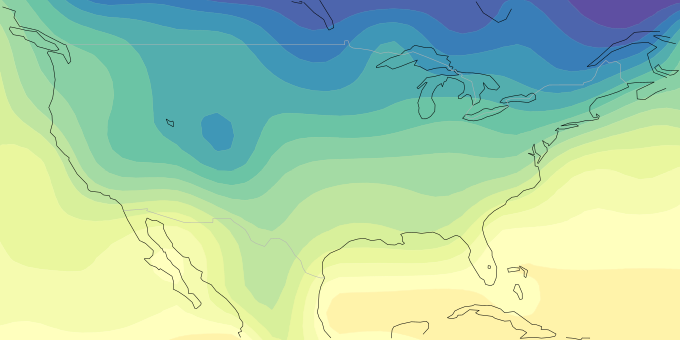

In [11]:
plot_temp(normalize(p.t2m))

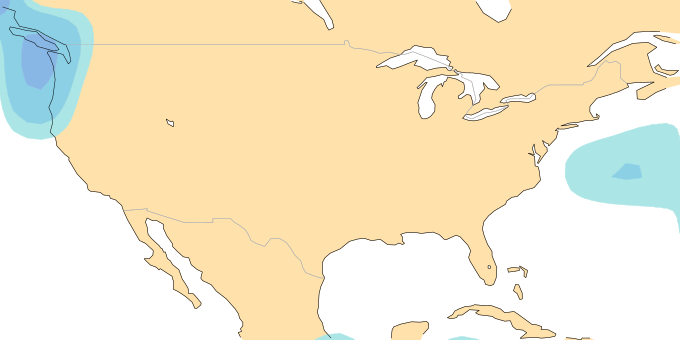

In [12]:
plot_rain(normalize(p.tp))

In [13]:
r = compute_weighted_rmse(normalize(p), normalize(test_data)).compute()
print('; '.join([f'{v} = {r[v].values}' for v in r]) + '\n')

t2m = 0.5922615426041251; tp = 1.2039313550239057



Now, we predict using our trained Linear Regressor on the final 30 days.

In [15]:
normalize(p.t2m)[-720:].to_netcdf('../data/us_temperature_lr_forecast.nc')

PermissionError: [Errno 13] Permission denied: b'/home/ubuntu/CSE6242_Weather_Forecasting/CODE/data/us_temperature_lr_forecast.nc'

In [16]:
p.tp[-720:].to_netcdf('../data/us_precipitation_lr_forecast.nc')

In [18]:
with open(f'../models/lr.pkl', 'wb') as f:
        pickle.dump(m, f)